# FDMT efficiency
The current FDMT seems to be a bit inefficient - i.e. we do the FDMT of a pulse and the peak in the FDMT should be the sum of the pulse - and it's not. Worrying.

In [36]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import fdmt # you'll need to have ../python in  you PYTHONPATH
import simfrb # in same directory as fdmt
from pylab import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [215]:
nf = 256 # number of channels - non-power-of-2 - naughty naughty!
fmax = 1440. #  Freuency of the top of the band in MHz
df = 1.0 # Channel bandwidth in MHz
fmin = fmax - nf*df # Frequency of the bottom of the band in MHz
nd = 512 # Number of DM trials to do
nt = 512 # Number of samples per block
tsamp = 1.0 # milliseconds

In [216]:
def mysimfrb(fmin, df, nf, tsamp, idt, nt, offset, width=0):
    assert df > 0
    assert nf > 0
    assert fmin > 0
    d = np.zeros((nf, nt))
    fmax = fmin + nf*df
    fmin /= 1e3
    fmax /= 1e3
    df /= 1e3
    dm1 = 4.15*(fmin**-2 - fmax**-2)
    dm = idt*tsamp/dm1
    
    assert dm1> 0
    
    for c in xrange(nf):
        f2 = fmin + c*df       
        offset_ms = -4.15*dm*(fmax**-2 - f2**-2) + offset
        offset_samp = int(np.round(offset_ms/tsamp)) 
        #print c, f2, fmax, offset_ms, offset_samp
        d[c, offset_samp] = 1
    return d

(0, 20.0)

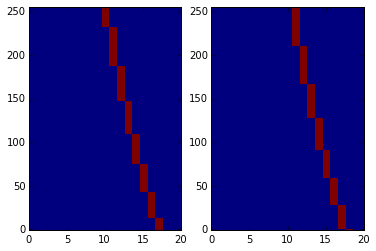

In [217]:
frb1 = mysimfrb(fmin, df, nf, tsamp, 7, nt, offset=10)
frb2 = mysimfrb(fmin, df, nf, tsamp, 7, nt, offset=10.5)

fig, ax = subplots(1,2)
ax[0].imshow(frb1, aspect='auto', origin='lower', interpolation='nearest')
ax[0].set_xlim(0,20.)

ax[1].imshow(frb2, aspect='auto', origin='lower', interpolation='nearest')
ax[1].set_xlim(0,20.)

In [218]:
def checkhit(thefdmt, dm, offset=0):
    # I haven't had time to tidy this up - the untis are funny and the FRB is updside down and transposed
    # With respect to what the FDMT wants to see - just trust me OK.
    # Caution: The DM units here are in pc/cm3 and the DM units the FDMT uses are in samples. at about 1 GHz and 1 ms these are almost identical.
    #frb = simfrb.mkfrb(fmax/1e3, -df/1e3, nf, tsamp=tsamp, dm=dm, ntimes=nt, offset=10).T
    #frb = np.flipud(frb)
    frb = mysimfrb(fmin, df, nf, tsamp, dm, nt, offset=offset)
    fout = thefdmt(frb)
    hitting_efficiency = fout.max()/frb.sum() # should be close to 1. Ideally 1.
    maxidx = fout.argmax()
    idtmax, tmax = np.unravel_index(maxidx, fout.shape)
    dm_of_idt = idtmax*tsamp/(4.15*((fmin/1e3)**-2 - (fmax/1e3)**-2)) # convert idt to pc/cm3
    #print 'Hitting efficiency', hitting_efficiency, 'Maximum at t=', tmax, 'idt=', idtmax, '=', dm_of_idt, 'pc/cm3'
    
    return (hitting_efficiency, idtmax, tmax)

In [222]:
thefdmt = fdmt.Fdmt( fmin, df, nf, nd, nt) # make FDMT
dmrange = np.arange(0, 300, 10)
hitdata = []
for dm in dmrange:
    hitdata.append(checkhit(thefdmt, dm, offset=10))
    
hitdata = np.array(hitdata)        

In [223]:
hitdata.shape

(30, 3)

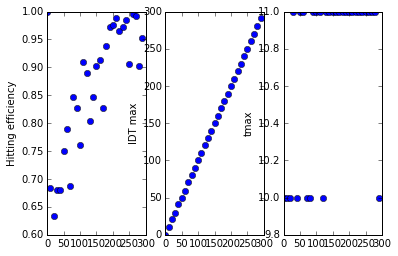

In [224]:
fig, ax = subplots(1,3, sharex=True)
ax[0].plot(dmrange, hitdata[:, 0], 'o')
ax[0].set_ylabel('Hitting efficiency ')
ax[1].plot(dmrange, hitdata[:, 1], 'o')
ax[1].set_ylabel('IDT max')
ax[2].plot(dmrange, hitdata[:, 2] - hitdata[:, 1], 'o')
ax[2].set_ylabel('tmax')

In [198]:
dm = 7
frb = mysimfrb(fmin, df, nf, tsamp, dm, nt, offset=10)
fout = thefdmt(frb)

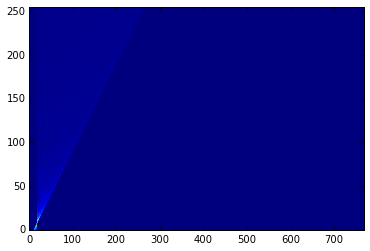

In [199]:
imshow(fout, aspect='auto', origin='lower')

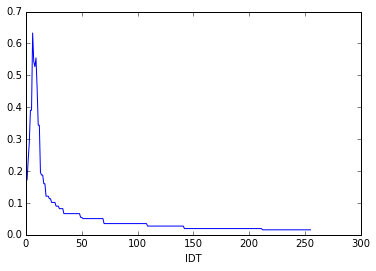

In [200]:
plot(fout.max(axis=1)/frb.sum())
xlabel('IDT')

In [201]:
frb.sum()

256.0